In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from lines_nuc import lines
from FitLines import *
from coaddData import *

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
font = 15
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
mpl.rc('font', family = 'serif', size = font)

mpl.rcParams['font.size'] = 15
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [2]:
wavebin_a = [1] # Width of wavelength bins for final histograms
wave_bins = [ np.arange(1000,2400,wavebin) for wavebin in wavebin_a ] # wavelength bins
wave_cen = [ (wb[1:] + wb[:-1])/2. for wb in wave_bins] # center of wavelength bins

In [3]:
# Load in data
prefix = './data/nucleus/'
exp_pre = [ "ldhv01k1q_", "ldhv01k3q_", "ldhv01k5q_", "ldhv01k7q_" ]
exp_pre.extend([ "ldhv02xvq_", "ldhv02xzq_", "ldhv02y1q_", "ldhv02y3q_" ])
for i in range(len(exp_pre)): exp_pre[i] = prefix+exp_pre[i]

# Variables we are interested in
keys = ['FLUX', 'WAVELENGTH', 'DQ', 'ERROR', 'GROSS', 'NET', 'BACKGROUND', 'GCOUNTS', 'BACKGROUND_PER_PIXEL', 'EXPTIME', 'NETCOUNTS'] 

In [4]:
# Get coadded data
comb_data = []
for wave_bin in wave_bins:
    comb_data.append(coaddData(exp_pre, keys, wave_bin)[-1])

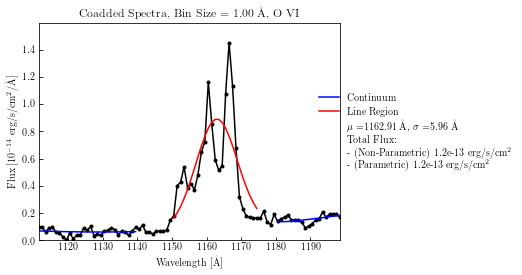

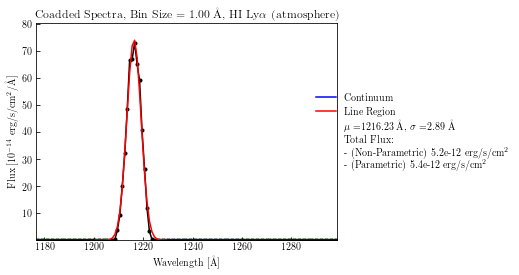

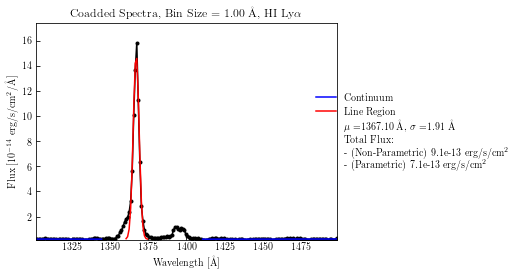

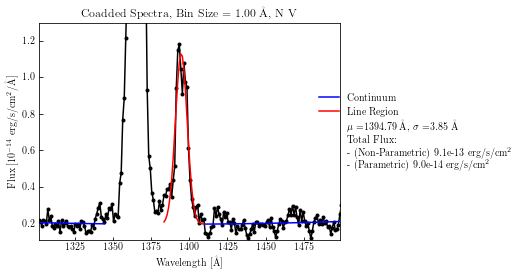

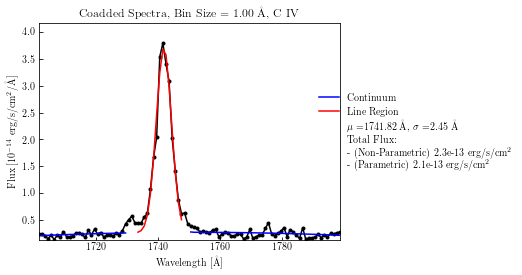

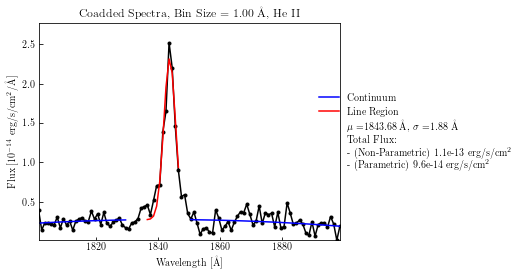

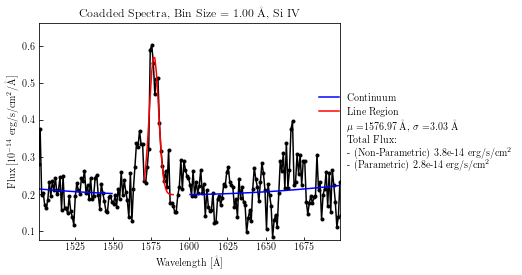

In [5]:
for iw in range(len(wave_bins)):
    for line in lines:
        coeff, _, p = getLineFit(lines[line], wave_cen, comb_data, [iw]) # Fit coefficients (coeff for gaussian, p for polynomial)
        flux_par, counts_par, counts_errlow_par, counts_errup_par = getLineCounts(coeff, p, lines[line], wave_cen, comb_data, [iw], par=True) # parameterized total flux, counts + errors
        flux_npar, counts_npar, counts_errlow_npar, counts_errup_npar = getLineCounts(coeff, p, lines[line], wave_cen, comb_data, [iw], par=False) # non-parameterized total flux, counts + errors
        _, line_ind, entire_ind = getIndices(lines[line], wave_cen[iw])
        
        # Plot spectrum with fit
        plt.figure()
        ax = plt.subplot(111)
        
        ax.errorbar(wave_cen[iw], comb_data[iw]['FLUX']*1e14, fmt=".-k", zorder=1, label="Stacked Spectra")[0]
        for c in lines[line]['continuum']:
            inds = (c[0] < wave_cen[iw])*(c[1] > wave_cen[iw])
            contp, = ax.plot(wave_cen[iw][inds], np.polyval(p[0], wave_cen[iw][inds])+gauss(wave_cen[iw][inds], *coeff[0]), c="blue")
        linep, = ax.plot(wave_cen[iw][line_ind], np.polyval(p[0], wave_cen[iw])[line_ind]+gauss(wave_cen[iw], *coeff[0])[line_ind], c="red")
        
        ax.set_xlabel(r"Wavelength [$\textup{\AA}$]")
        ax.set_ylabel(r"Flux [$10^{-14}$ erg/s/cm$^2$/$\textup{\AA}$]")
        ax.set_title((r"Coadded Spectra, Bin Size = %1.2f $\textup{\AA}$, "+str(line))%wavebin_a[iw])
        ax.set_ylim(min(comb_data[iw]['FLUX'][entire_ind]*1e14)*0.9, max(comb_data[iw]['FLUX'][line_ind]*1e14)*1.1)
        ax.set_xlim(min(wave_cen[iw][entire_ind]),max(wave_cen[iw][entire_ind]))
        
        text1 = r'$\mu = $%4.2f $\textup{\AA}$, $\sigma =$%4.2f $\textup{\AA}$'%(coeff[0][1], coeff[0][2])
        text2 = r'Total Flux:'
        text2 += '\n - (Non-Parametric) %4.1e erg/s/cm$^2$'%flux_npar[0]
        text2 += '\n - (Parametric) %4.1e erg/s/cm$^2$'%flux_par[0]
        
        t1, = ax.plot([], [], ' ')
        t2, = ax.plot([], [], ' ')
        
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
        ax.legend([contp, linep, t1, t2],["Continuum", "Line Region", text1, text2], frameon=False, loc='center left', bbox_to_anchor=(0.9, 0.5))
        plt.show()

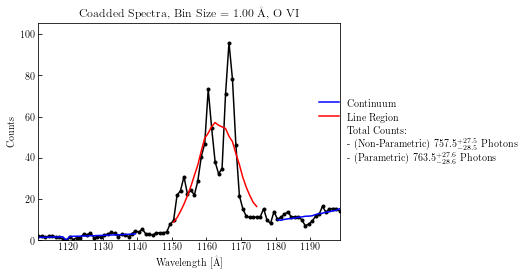

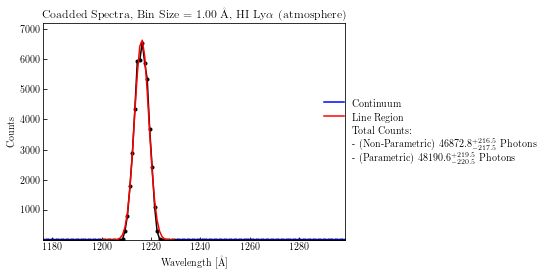

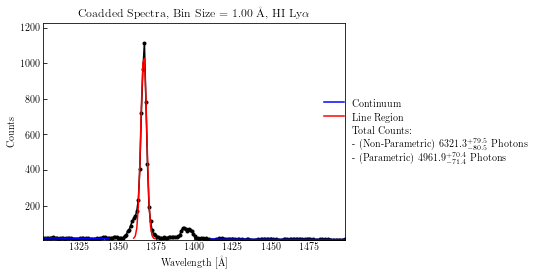

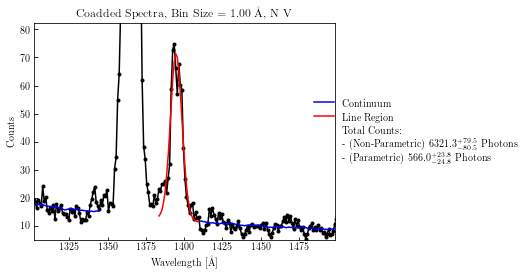

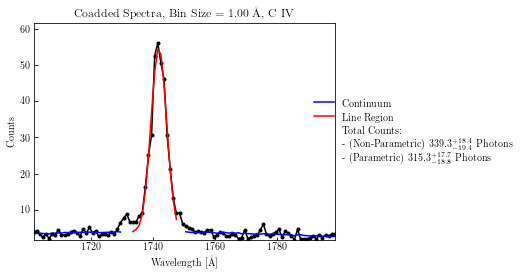

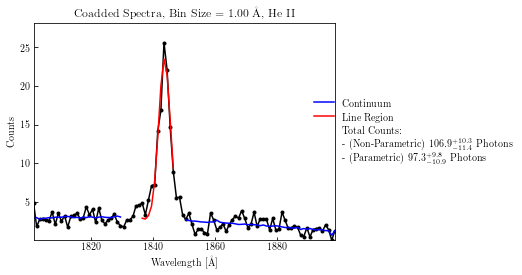

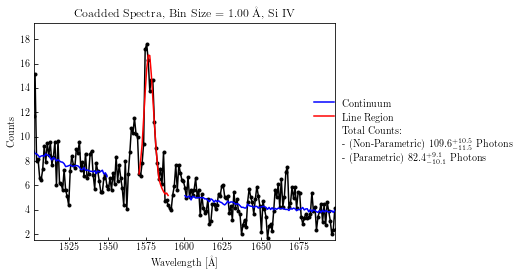

In [6]:
for iw in range(len(wave_bins)):
    countsflux_conv = comb_data[iw]['NETCOUNTS']/np.maximum(1e-50, comb_data[iw]['FLUX']) # Conversion factor, flux to counts
    countsflux_conv[np.isnan(countsflux_conv)] = 0
    for line in lines:
        coeff, _, p = getLineFit(lines[line], wave_cen, comb_data, [iw]) # Fit coefficients (coeff for gaussian, p for polynomial)
        flux_par, counts_par, counts_errlow_par, counts_errup_par = getLineCounts(coeff, p, lines[line], wave_cen, comb_data, [iw], par=True) # parameterized total flux, counts + errors
        flux_npar, counts_npar, counts_errlow_npar, counts_errup_npar = getLineCounts(coeff, p, lines[line], wave_cen, comb_data, [iw], par=False) # non-parameterized total flux, counts + errors
        _, line_ind, entire_ind = getIndices(lines[line], wave_cen[iw])
        
        # Plot counts with fit
        plt.figure()
        ax = plt.subplot(111)
        
        ax.errorbar(wave_cen[iw], comb_data[iw]['FLUX']*countsflux_conv, fmt=".-k", zorder=1, label="Stacked Spectra")[0]
        for c in lines[line]['continuum']:
            inds = (c[0] < wave_cen[iw])*(c[1] > wave_cen[iw])
            contp, = ax.plot(wave_cen[iw][inds], (np.polyval(p[0], wave_cen[iw][inds])+gauss(wave_cen[iw][inds], *coeff[0]))*countsflux_conv[inds]/1e14, c="blue")
        linep, = ax.plot(wave_cen[iw][line_ind], (np.polyval(p[0], wave_cen[iw])[line_ind]+gauss(wave_cen[iw], *coeff[0])[line_ind])*countsflux_conv[line_ind]/1e14, c="red")


        ax.set_xlabel(r"Wavelength [$\textup{\AA}$]")
        ax.set_ylabel(r"Counts")
        ax.set_title((r"Coadded Spectra, Bin Size = %1.2f $\textup{\AA}$, "+str(line))%wavebin_a[iw])
        ax.set_ylim(min(comb_data[iw]['FLUX'][entire_ind]*countsflux_conv[entire_ind])*0.9, max(comb_data[iw]['FLUX'][line_ind]*countsflux_conv[line_ind])*1.1)
        ax.set_xlim(min(wave_cen[iw][entire_ind]),max(wave_cen[iw][entire_ind]))

        text = 'Total Counts:'
        text += '\n - (Non-Parametric) $%4.1f^{+%4.1f}_{-%4.1f}$ Photons'%(counts_par[0], counts_errlow_par[0], counts_errup_par[0])
        text += '\n - (Parametric) $%4.1f^{+%4.1f}_{-%4.1f}$ Photons'%(counts_npar[0], counts_errlow_npar[0], counts_errup_npar[0])
        t, = ax.plot([], [], ' ')
        
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
        ax.legend([contp, linep, t],["Continuum", "Line Region", text], frameon=False, loc='center left', bbox_to_anchor=(0.9, 0.5))
        plt.show()